In [1]:
!pip install gym-anytrading gym
!pip install sb3-contrib



In [2]:
%load_ext autoreload
%autoreload 2

# Gym stuff
# import gym
import gymnasium as gym
import gym_anytrading

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from sb3_contrib import RecurrentPPO

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [3]:
df = pd.read_csv('data/BTCUSD/BTCUSD_daily.csv')

df.head()

,datetime,symbol,open,high,low,close,volume
0,2014-12-01 08:00:00,COINBASE:BTCUSD,300.0,370.0,300.00,370.0,0.0
1,2014-12-02 08:00:00,COINBASE:BTCUSD,377.0,378.0,377.00,378.0,15.0
2,2014-12-03 08:00:00,COINBASE:BTCUSD,377.9,378.0,377.01,378.0,0.0
3,2014-12-04 08:00:00,COINBASE:BTCUSD,377.1,377.1,377.10,377.1,0.0
4,2014-12-06 08:00:00,COINBASE:BTCUSD,378.0,378.0,378.00,378.0,0.0


In [4]:
df = df.drop("symbol", axis=1)

df.head()

,datetime,open,high,low,close,volume
0,2014-12-01 08:00:00,300.0,370.0,300.00,370.0,0.0
1,2014-12-02 08:00:00,377.0,378.0,377.00,378.0,15.0
2,2014-12-03 08:00:00,377.9,378.0,377.01,378.0,0.0
3,2014-12-04 08:00:00,377.1,377.1,377.10,377.1,0.0
4,2014-12-06 08:00:00,378.0,378.0,378.00,378.0,0.0


In [34]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.dtypes

datetime    datetime64[ns]
open               float64
high               float64
low                float64
close              float64
volume             float64
dtype: object

In [5]:
df.sort_values('datetime', ascending=True, inplace=True)
df.head()

,datetime,open,high,low,close,volume
0,2014-12-01 08:00:00,300.0,370.0,300.00,370.0,0.0
1,2014-12-02 08:00:00,377.0,378.0,377.00,378.0,15.0
2,2014-12-03 08:00:00,377.9,378.0,377.01,378.0,0.0
3,2014-12-04 08:00:00,377.1,377.1,377.10,377.1,0.0
4,2014-12-06 08:00:00,378.0,378.0,378.00,378.0,0.0


In [6]:
df.set_index('datetime', inplace=True)
df.head()

,open,high,low,close,volume
datetime,,,,,
2014-12-01 08:00:00,300.0,370.0,300.00,370.0,0.0
2014-12-02 08:00:00,377.0,378.0,377.00,378.0,15.0
2014-12-03 08:00:00,377.9,378.0,377.01,378.0,0.0
2014-12-04 08:00:00,377.1,377.1,377.10,377.1,0.0
2014-12-06 08:00:00,378.0,378.0,378.00,378.0,0.0


In [7]:
df.columns = [col.capitalize() for col in df.columns]

env = gym.make('stocks-v0', df=df, frame_bound=(2400, 3000), window_size=12)

In [8]:
env_unwrapped = env.unwrapped
env_unwrapped.signal_features


array([[30842.03,     0.  ],
       [29796.16, -1045.87],
       [32135.19,  2339.03],
       ...,
       [27823.32,  -231.14],
       [28207.33,   384.01],
       [27325.15,  -882.18]], dtype=float32)

In [9]:
env.action_space

Discrete(2)

info {'total_reward': -3558.1181640625, 'total_profit': 0.10753684309290006, 'position': <Positions.Short: 0>}


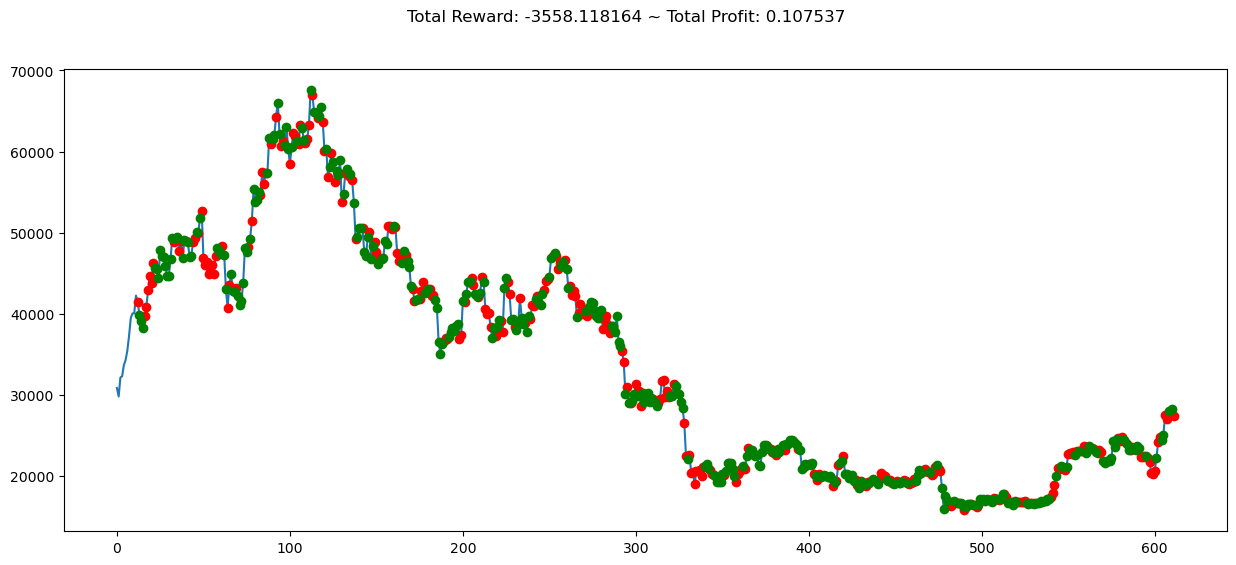

In [10]:
state, info = env.reset()
while True: 
    action = env.action_space.sample()
    n_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done: 
        print("info", info)
        break

plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()


In [49]:
# vec_env = DummyVecEnv([lambda: env])

# model = A2C("MlpPolicy", vec_env, verbose=1)
# model.learn(total_timesteps=1000000) 

env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(2400, 3000), window_size=12)
env = DummyVecEnv([env_maker])

model = A2C("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=1000000) 


Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 2564     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.572   |
|    explained_variance | -17.6    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.0332   |
|    value_loss         | 0.0207   |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2663      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -0.398    |
|    explained_variance | -2.38e-07 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    policy_loss        | -1.51e+03 |
|    valu

In [53]:
# env = MultiAssetTradingEnv(
#     df=df,
#     window_size=5,
#     frame_bound=(3000, 3120),
#     trade_fee_bid_percent=0.01,
#     trade_fee_ask_percent=0.005,
#     asset_name='BTCUSD'
# )
# obs, _ = env.reset()

env = gym.make('stocks-v0', df=df, frame_bound=(3000, 3120), window_size=12)
obs, _ = env.reset()
# while True: 
#     obs = obs[np.newaxis, ...]
#     action, _states = model.predict(obs)
#     obs, rewards, done, info = env.step(action)
#     if done:
#         print("info", info)
#         break

while True: 
    obs = obs[np.newaxis, ...]  # Add batch dimensiona
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print("info", info)
        break

info {'total_reward': 0.0, 'total_profit': 1.068181008375365, 'position': <Positions.Long: 1>}


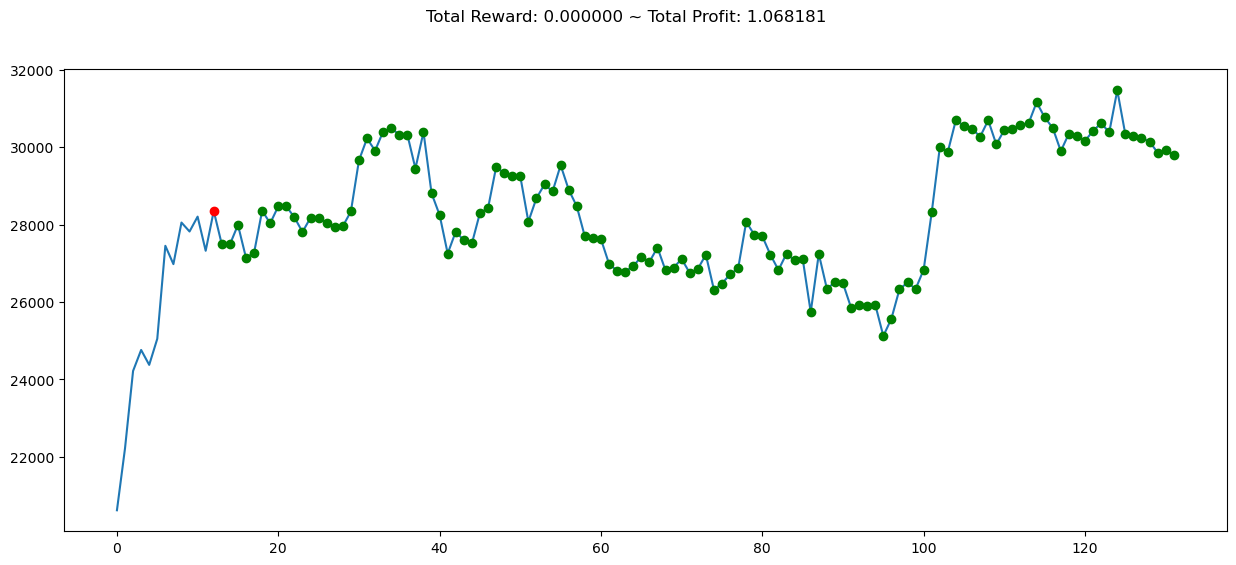

In [54]:
plt.figure(figsize=(15,6))
plt.cla()
env.unwrapped.render_all()
plt.show()